# Projeto de previsão de Querys de SQL Injection

## Importações

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from keras.layers import Dense, Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importação do Dataframe

faça o download pelo link: https://www.kaggle.com/datasets/hrishi1563/sql-injection-dataset-with-sqlfeaturesvalue/data

In [2]:
df = pd.read_csv("SQL_Injection.csv", dtype={"Query": str})
df.describe()

,Label,Sentence Length,AND Count,OR Count,UNION Count,Single Quote Count,Double Quote Count,Constant Value Count,Parentheses Count,Special Characters Total
count,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000,30919.000000
mean,0.368123,68.594845,0.239626,0.127430,0.097222,0.833468,0.256703,2.213914,3.127494,1.447233
std,0.482303,81.068616,0.520416,0.348911,0.330919,1.663833,0.863389,3.529712,6.687481,3.909025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,80.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,1.000000
max,1.000000,5370.000000,6.000000,4.000000,3.000000,13.000000,20.000000,32.000000,44.000000,320.000000


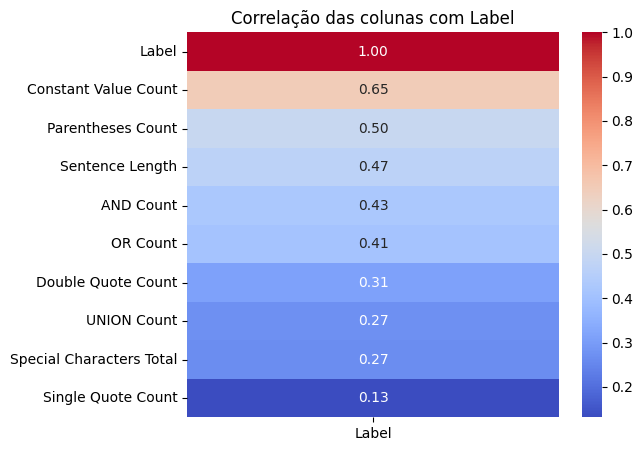

In [3]:
df_corr = df.drop(columns=["Query"]).corr()

label_corr = df_corr[["Label"]].sort_values(by="Label", ascending=False)

plt.figure(figsize=(6, len(label_corr)*0.5))
sns.heatmap(label_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlação das colunas com Label")
plt.show()

In [4]:
y = df["Label"].values

In [5]:
vectorizer = TfidfVectorizer(max_features=100)
x_query = vectorizer.fit_transform(df["Query"]).toarray()

x_tabular = df.drop(columns=["Label", "Query"]).values

x = np.hstack([x_query, x_tabular])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_tabular,y, test_size=0.3, random_state=42)

In [7]:
mlp = Sequential()
mlp.add(Input(shape=(x_train.shape[1],)))
mlp.add(Dense(2, activation='relu'))
mlp.add(Dense(2, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

In [8]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
mlp.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])

In [10]:
mlp.fit(x_train, y_train, epochs=150, verbose=1)

Epoch 1/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6333 - loss: 0.6710
Epoch 2/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6333 - loss: 0.6581
Epoch 3/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 4/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 5/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 6/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 7/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 8/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 9/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 10/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 11/150
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6333 - loss: 0.6572
Epoch 12/150
677/677 ━━━━━━━━━━━━━━━━━━━━

In [11]:
_, acuracia = mlp.evaluate(x_test, y_test)
print("Acurácia: %.2f" %(acuracia*100))

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6285 - loss: 0.6598
Acurácia: 62.85


In [12]:
previsoes = mlp.predict(x_test, verbose=1)
rounded_previsoes = [round(x[0]) for x in previsoes]

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

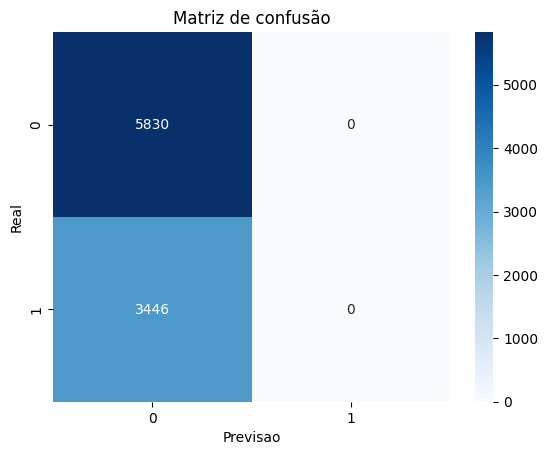

In [14]:
conf_mat = confusion_matrix(y_test, rounded_previsoes)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Previsao')
plt.ylabel('Real')
plt.title('Matriz de confusão')
plt.show()